<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/Ensemble_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Descriptions

In [1]:
!rm -r airbnb_price

In [2]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1280, done.
remote: Counting objects: 100% (1280/1280), done.
remote: Compressing objects: 100% (1207/1207), done.
remote: Total 1280 (delta 774), reused 334 (delta 63), pack-reused 0
Receiving objects: 100% (1280/1280), 10.62 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (774/774), done.


In [3]:
#@title also import libraries
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
sys.path.append("/content/airbnb_price/models")
from ensemble_model import EnsembleModel2, EnsembleDataset2
import train_ensemble2 as train
import general_utils as ut
device = ut.get_device()

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [4]:
#@title Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import json
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import sklearn

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Loading

In [7]:
desc = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/descriptions.pickle")
rev = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle")
thumb = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/thumbnails.pickle")
features = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_embeddedcats.pickle")
with open("/content/drive/MyDrive/Colab/airbnb/data/data1/catdict.json", "r") as f:
    catlist = json.load(f)

In [8]:
# if you want to set desc, rev and thumb to zero for performance comparison, run this chunk

# for i in range(len(desc)):
#     desc.iloc[i] = [0 for i in range(len(desc.iloc[0]))]

# for i in range(len(rev)):
#     rev.iloc[i] = [0 for i in range(len(rev.iloc[0]))]

# for i in range(len(thumb)):
#     thumb.iloc[i] = [0 for i in range(len(thumb.iloc[0]))]

In [9]:
dropset = set()

In [10]:
# # if you want to exclude columns in training (used for munich), run this chunk

# features = features.drop(["calculated_host_listings_count_private_rooms", "calculated_host_listings_count_entire_homes", 
#                           "calculated_host_listings_count", "longitude", "latitude", "neighbourhood_cleansed",
#                           'host_verification_photographer', 'host_verification_sesame', 'host_verification_sesame_offline',
#                           'host_verification_weibo','host_verification_zhima_selfie'], axis=1)
# dropset = set(["calculated_host_listings_count_private_rooms", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count", "longitude", "latitude", "neighbourhood_cleansed"])

In [11]:
logprice = features["log_price"]

In [12]:
selected_features = np.load("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features2.npy", allow_pickle=True)

In [13]:
selected_features = np.load("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features2.npy", allow_pickle=True)
selected_features = (set(selected_features) & set(features.columns)) | (set(['neighbourhood_cleansed', 'property_type', 'room_type', "lang"]) - dropset)
features = features[selected_features]

In [14]:
# if you want to set all values of tabular variables to 0 (used to use only unstructured data), run this
# features.loc[:, :] = 0

In [15]:
desc = pd.DataFrame(desc)
thumb = pd.DataFrame(thumb)
rev = pd.DataFrame(rev)
logprice = pd.DataFrame(logprice)

In [16]:
data = pd.concat([thumb, desc, rev, features, logprice], axis=1)

# define which of the (possibly 7) data columns are treated as categories

In [17]:
# choose to exclude some columns from the cat_cols
cat_cols_regular = ['neighbourhood_cleansed', 
                    'property_type', 
                    'room_type', 
                    'lang', 
                    "availability_30", 
                    "accommodates", 
                    "bedrooms"]

cat_cols_exclude = [#'neighbourhood_cleansed', 
                    #'property_type', 
                    #'room_type', 
                    'lang', 
                    #"availability_30", 
                    "accommodates", 
                    "bedrooms"
                    ]


cat_cols = cat_cols_regular.copy()
for x in cat_cols_exclude:
    cat_cols.remove(x)

rm_list = []
for i, col in enumerate(cat_cols_regular):
    if col in set(cat_cols_exclude):
        rm_list.append(i)

for i in rm_list[::-1]:
    del catlist[i]

to_replace = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")

if "neighbourhood_cleansed" in cat_cols_exclude:
    cat_cols_exclude.remove("neighbourhood_cleansed")
    data.loc[:, "neighbourhood_cleansed_Simmering"] = to_replace["neighbourhood_cleansed_Simmering"]
    data.loc[:, "neighbourhood_cleansed_Brigittenau"] = to_replace["neighbourhood_cleansed_Brigittenau"]
    data.loc[:, "neighbourhood_cleansed_Ottakring"] =  to_replace["neighbourhood_cleansed_Ottakring"]
    data.loc[:, "neighbourhood_cleansed_W\x8ahring"] =  to_replace["neighbourhood_cleansed_W\x8ahring"]
    data.loc[:, "neighbourhood_cleansed_Wieden"] =  to_replace["neighbourhood_cleansed_Wieden"]
    data.loc[:, "neighbourhood_cleansed_Hietzing"] =  to_replace["neighbourhood_cleansed_Hietzing"]
    data.loc[:, "neighbourhood_cleansed_Innere Stadt"] =  to_replace["neighbourhood_cleansed_Innere Stadt"]
    data = data.drop("neighbourhood_cleansed", axis=1)

if "property_type" in cat_cols_exclude:
    cat_cols_exclude.remove("property_type")
    data.loc[:, "property_type_shared_room"] =  to_replace["property_type_shared_room"]
    data.loc[:, "property_type_private_room"] =  to_replace["property_type_private_room"]
    data = data.drop("property_type", axis=1)

if "room_type" in cat_cols_exclude:
    cat_cols_exclude.remove("room_type")
    data.loc[:, "room_Private room"] =  to_replace["room_Private room"]
    data.loc[:, "room_Shared room"] =  to_replace["room_Shared room"]   
    data = data.drop("room_type", axis=1)

if "lang" in cat_cols_exclude:
    cat_cols_exclude.remove("lang")
    data = data.drop("lang", axis=1)

data.loc[:, cat_cols_exclude] = to_replace[cat_cols_exclude]

In [18]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)
traindf, valdf, testdf = data.loc[train_ids], data.loc[val_ids], data.loc[test_ids]

## Create DataLoader

In [19]:
# if you want to remove something from catcols and catlist (used for munich), run this
# del cat_cols[0]
# del catlist[0]

In [20]:
# TODO
# create dataloaders
trainset = EnsembleDataset2(traindf, ["thumbnails"], ["descriptions"], ["reviews"], cat_cols, ["log_price"])
valset = EnsembleDataset2(valdf, ["thumbnails"], ["descriptions"], ["reviews"], cat_cols, ["log_price"])
testset = EnsembleDataset2(testdf, ["thumbnails"], ["descriptions"], ["reviews"], cat_cols, ["log_price"])

b = 128
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)
testloader = DataLoader(testset, shuffle=False, num_workers=2, batch_size=b)


#Training


In [21]:
no_of_thumb = 100
no_of_desc = 100
no_of_rev = 100
no_of_cont = len(traindf.columns) - 3 - 1 - len(catlist)  # -3 for thumb, desc and rev, -1 for price, last term to subtract cat cols
cat_emb_dims = [(len(x), 16) for x in catlist]
lin_layer_sizes = [512, 512, 512, 512, 512]

In [22]:
model = EnsembleModel2(no_of_thumb=no_of_thumb, no_of_desc=no_of_desc, no_of_rev=no_of_rev, no_of_cont=no_of_cont,
                      cat_emb_dims=cat_emb_dims, lin_layer_sizes=lin_layer_sizes, thumb_dropout=0.6, desc_dropout=0.6,
                      rev_dropout=0.6, cont_dropout=0, cat_dropout=0, linear_layer_dropout=[0, 0, 0, 0, 0], bn_layers=False)


model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.1 ** (epoch // 15), last_epoch=- 1, verbose=True)
result = train.run_training(model, optimizer, loss_fn, device, 40, trainloader, 
                            valloader, verbose=True, ntrain=500, nval=200, scheduler=scheduler, savefolder="fuck")

Adjusting learning rate of group 0 to 1.0000e-03.


saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
saving model...
Adjusting learning rate of group 0 to 1.0000e-04.
saving model...
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 

# Evaluation of final model

In [23]:
# calculate mean logprice on testset
mean_logprice = 0

for     _, _, _, _, _, logprice  in testset:
    mean_logprice += np.array(logprice)

mean_logprice = mean_logprice/ len(testset)

mean_logprice

mse =  0
for _, _, _, _, _, logprice  in testset:
    mse += (logprice - mean_logprice)**2

mse = mse / len(testset)
mse    

tensor([0.4106])

In [25]:
# load statedict of saved model

no_of_thumb = 100
no_of_desc = 100
no_of_rev = 100
no_of_cont = len(traindf.columns) - 3 - 1 - len(catlist)  # -3 for thumb, desc and rev, -1 for price, last term to subtract cat cols
cat_emb_dims = [(len(x), 16) for x in catlist]
lin_layer_sizes = [512, 512, 512, 512, 512]

model = EnsembleModel2(no_of_thumb=no_of_thumb, no_of_desc=no_of_desc, no_of_rev=no_of_rev, no_of_cont=no_of_cont,
                      cat_emb_dims=cat_emb_dims, lin_layer_sizes=lin_layer_sizes, thumb_dropout=0.6, desc_dropout=0.6,
                      rev_dropout=0.6, cont_dropout=0, cat_dropout=0, linear_layer_dropout=[0, 0, 0, 0, 0], bn_layers=False)

# load statedict and model performances
savefolder = "fuck"
state_dict = torch.load("/content/drive/MyDrive/Colab/airbnb/data/model_performance/" + savefolder + "/checkpoint.pt")
train_rmse = np.load("/content/drive/MyDrive/Colab/airbnb/data/model_performance/" + savefolder + "/trainloss.npy")
val_rmse = np.load("/content/drive/MyDrive/Colab/airbnb/data/model_performance/" + savefolder + "/valloss.npy")

model.load_state_dict(state_dict)

<All keys matched successfully>

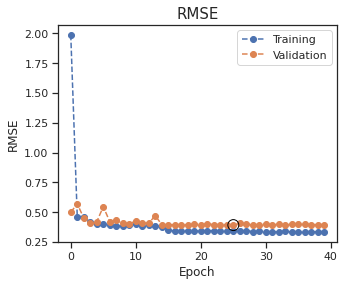

0.3916164466032472


In [26]:
# plot train and test
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear', save_path="/content/file0.svg")
print(np.min(val_rmse))

In [29]:
# compute predictions

ypreds = []
ys = []
model = model.to(device)
with torch.no_grad():
    model = model.eval()

    for pic_embdg, description_embdg, reviews_embdg, cont_features, cat_features, label in tqdm(valloader):

        pic_embdg, description_embdg, reviews_embdg, cont_features, cat_features = \
        pic_embdg.to(device), description_embdg.to(device), reviews_embdg.to(device), cont_features.to(device), cat_features.to(device).int()
        
        y_pred = model(pic_embdg, description_embdg, reviews_embdg, cont_features, cat_features)
        y_pred = list(y_pred.detach().cpu())
        
        ypreds = ypreds + y_pred
        ys = ys + list(label)




100%|██████████| 14/14 [00:00<00:00, 44.83it/s]


(0.8002294420954855, 0.0)


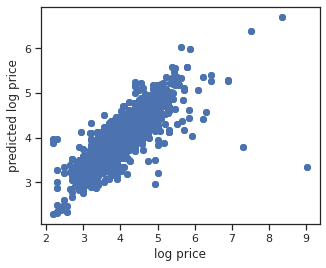

In [30]:
ys = [i.item() for i in ys]
ypreds = [i.item() for i in ypreds]

print(pearsonr(ys, ypreds))
plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [31]:
import sklearn
np.sqrt(sklearn.metrics.mean_squared_error(ys, np.squeeze(ypreds)))

0.39239346389006663

In [32]:
sklearn.metrics.r2_score(ys, ypreds)

0.6344359095000139

# Evaluation of Munich model

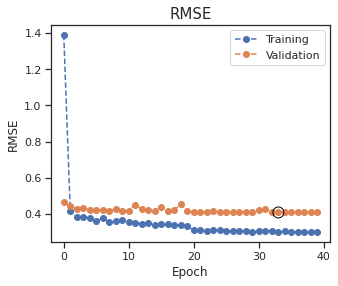

In [ ]:
tl, vl, tm, vm = result
ut.plot("RMSE", "RMSE", tm, vm, yscale='linear', save_path="/content/file0.svg")

In [ ]:
desc = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/embeddings/descriptions.pickle")
rev = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/embeddings/reviews.pickle")
thumb = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/thumbnails/thumbnails_embeddings.pickle")
features = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/listings_embeddedcats.pickle")
with open("/content/drive/MyDrive/Colab/airbnb/munich/catdict.json", "r") as f:
    catlist = json.load(f)

# if you want to exclude columns in training, run this chunk

features = features.drop(["calculated_host_listings_count_private_rooms", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count", "longitude", "latitude", "neighbourhood_cleansed"], axis=1)
dropset = set(["calculated_host_listings_count_private_rooms", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count", "longitude", "latitude", "neighbourhood_cleansed"])

logprice = features["log_price"]

selected_features = np.load("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features2.npy", allow_pickle=True)
selected_features = (set(selected_features) & set(features.columns)) | (set(['neighbourhood_cleansed', 'property_type', 'room_type', 'lang']) - dropset)
features = features[selected_features]

desc = pd.DataFrame(desc)
thumb = pd.DataFrame(thumb)
rev = pd.DataFrame(rev)
logprice = pd.DataFrame(logprice)

data = pd.concat([thumb, desc, rev, features, logprice], axis=1)


# choose to exclude some columns from the cat_cols
cat_cols_regular = ['neighbourhood_cleansed', 
                    'property_type', 
                    'room_type', 
                    'lang', 
                    "availability_30", 
                    "accommodates", 
                    "bedrooms"]

cat_cols_exclude = [#'neighbourhood_cleansed', 
                    #'property_type', 
                    #'room_type', 
                    #'lang', 
                    #"availability_30", 
                    "accommodates", 
                    "bedrooms"
                    ]


cat_cols = cat_cols_regular.copy()
for x in cat_cols_exclude:
    cat_cols.remove(x)

rm_list = []
for i, col in enumerate(cat_cols_regular):
    if col in set(cat_cols_exclude):
        rm_list.append(i)

for i in rm_list[::-1]:
    del catlist[i]

to_replace = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/munich/listings_workfile.pickle")

if "neighbourhood_cleansed" in cat_cols_exclude:
    cat_cols_exclude.remove("neighbourhood_cleansed")
    data.loc[:, "neighbourhood_cleansed_Simmering"] = to_replace["neighbourhood_cleansed_Simmering"]
    data.loc[:, "neighbourhood_cleansed_Brigittenau"] = to_replace["neighbourhood_cleansed_Brigittenau"]
    data.loc[:, "neighbourhood_cleansed_Ottakring"] =  to_replace["neighbourhood_cleansed_Ottakring"]
    data.loc[:, "neighbourhood_cleansed_W\x8ahring"] =  to_replace["neighbourhood_cleansed_W\x8ahring"]
    data.loc[:, "neighbourhood_cleansed_Wieden"] =  to_replace["neighbourhood_cleansed_Wieden"]
    data.loc[:, "neighbourhood_cleansed_Hietzing"] =  to_replace["neighbourhood_cleansed_Hietzing"]
    data.loc[:, "neighbourhood_cleansed_Innere Stadt"] =  to_replace["neighbourhood_cleansed_Innere Stadt"]
    data = data.drop("neighbourhood_cleansed", axis=1)

if "property_type" in cat_cols_exclude:
    cat_cols_exclude.remove("property_type")
    data.loc[:, "property_type_shared_room"] =  to_replace["property_type_shared_room"]
    data.loc[:, "property_type_private_room"] =  to_replace["property_type_private_room"]
    data = data.drop("property_type", axis=1)

if "room_type" in cat_cols_exclude:
    cat_cols_exclude.remove("room_type")
    data.loc[:, "room_Private room"] =  to_replace["room_Private room"]
    data.loc[:, "room_Shared room"] =  to_replace["room_Shared room"]   
    data = data.drop("room_type", axis=1)

if "lang" in cat_cols_exclude:
    cat_cols_exclude.remove("lang")
    data = data.drop("lang", axis=1)

data.loc[:, cat_cols_exclude] = to_replace[cat_cols_exclude]


# if you want to remove something from catcols and catlist, run this
del cat_cols[0]
del catlist[0]


# TODO
# create dataloaders
testset = EnsembleDataset2(data, ["thumbnails"], ["descriptions"], ["reviews"], cat_cols, ["log_price"])

b = 128
testloader = DataLoader(testset, shuffle=True, num_workers=2, batch_size=b)

In [ ]:
no_of_thumb = 100
no_of_desc = 100
no_of_rev = 100
no_of_cont = len(traindf.columns) - 3 - 1 - len(catlist)  # -3 for thumb, desc and rev, -1 for price, last term to subtract cat cols
cat_emb_dims = [(len(x), 10) for x in catlist]
lin_layer_sizes = [512, 512, 512, 512, 512]

model = EnsembleModel2(no_of_thumb=no_of_thumb, no_of_desc=no_of_desc, no_of_rev=no_of_rev, no_of_cont=no_of_cont,
                       cat_emb_dims=cat_emb_dims, lin_layer_sizes=lin_layer_sizes, thumb_dropout=0.3, desc_dropout=0.3,
                       rev_dropout=0.2, cont_dropout=0, cat_dropout=0, linear_layer_dropout=[0, 0, 0], bn_layers=False)

# load statedict and model performances
savefolder = "munich_modeltmp"
state_dict = torch.load("/content/drive/MyDrive/Colab/airbnb/data/model_performance/" + savefolder + "/checkpoint.pt")
model.load_state_dict(state_dict)
train_rmse = np.load("/content/drive/MyDrive/Colab/airbnb/data/model_performance/" + savefolder + "/trainloss.npy")
val_rmse = np.load("/content/drive/MyDrive/Colab/airbnb/data/model_performance/" + savefolder + "/valloss.npy")

In [ ]:
model = model.to(device)
ypreds = []
ys = []

with torch.no_grad():
    model = model.eval()

    for pic_embdg, description_embdg, reviews_embdg, cont_features, cat_features, label in tqdm(testloader):

        pic_embdg, description_embdg, reviews_embdg, cont_features, cat_features = \
        pic_embdg.to(device), description_embdg.to(device), reviews_embdg.to(device), cont_features.to(device), cat_features.to(device).int()
        
        y_pred = model(pic_embdg, description_embdg, reviews_embdg, cont_features, cat_features)
        y_pred = list(y_pred.detach().cpu())
        
        ypreds = ypreds + y_pred
        ys = ys + list(label)


100%|██████████| 8/8 [00:00<00:00, 40.29it/s]


(0.5775360479018536, 7.536920555454828e-90)


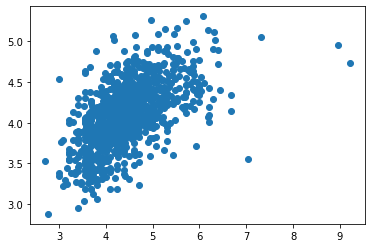

In [ ]:
ys = [i.item() for i in ys]
ypreds = [i.item() for i in ypreds]




print(pearsonr(ys, ypreds))
plt.scatter(ys, ypreds)
plt.show()

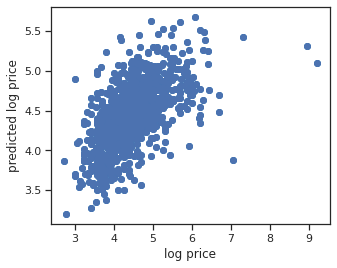

In [ ]:
plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [ ]:
import sklearn

sklearn.metrics.mean_squared_error(ys, ypreds)

0.44182635902559514

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(np.array(ypreds).reshape(-1, 1), np.array(ys).reshape(-1,1))
ypreds = ypreds * reg.coef_ + reg.intercept_

In [ ]:
sklearn.metrics.mean_squared_error(ys, np.squeeze(ypreds))

0.3238342326182796

In [ ]:
reg.coef_

array([[1.02402179]])

In [ ]:
reg.intercept_

array([0.24499807])

# Explainability categorical variables

In [ ]:
embeddings = np.empty((len(catlist[0]), 16))

for i in range(len(catlist[0])):
    embedding = model.generate_cat_embeddings(variable_number=0, category_number=i)
    embedding = embedding.numpy()
    embeddings[i] = embedding

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, perplexity=20)  # perplexity=x argument possible
tsne_results = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
districts = ['Donaustadt', 'Leopoldstadt', 'Rudolfsheim-Fuenfhaus', 'Ottakring', 'Brigittenau', 'Neubau', 'Margareten',
             'Hernals', 'Floridsdorf', 'Alsergrund', 'Simmering', 'Wieden', 'Mariahilf', 'Josefstadt', 'Landstrasse',
             'Favoriten', 'Innere Stadt', 'Meidling', 'Wöhring', 'Döbling', 'Penzing', 'Liesing', 'Hietzing']

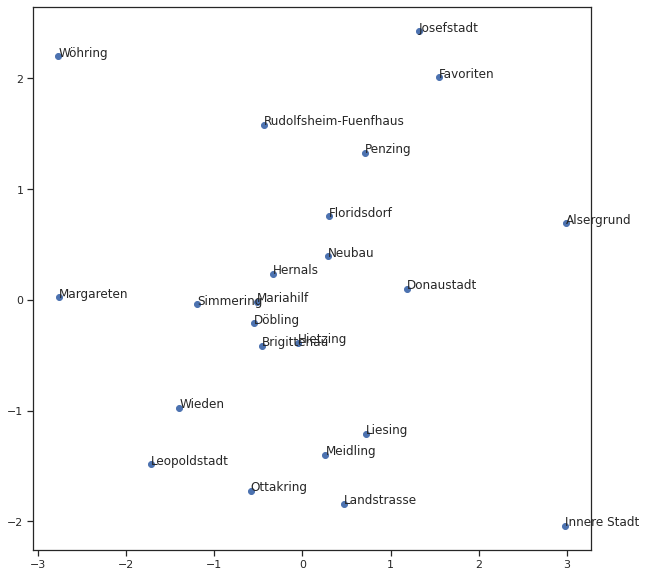

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(pca_results[:, 0], pca_results[:, 1])

for i, txt in enumerate(districts):
    ax.annotate(districts[i], (pca_results[:, 0][i], pca_results[:, 1][i]))

plt.show()

In [ ]:
import sklearn
pca = sklearn.decomposition.PCA(n_components=2)

In [ ]:
pca_results = pca.fit_transform(embeddings)